In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>The raw code for this IPython notebook is by default hidden for easier reading.To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></b>''')

# Meta Analysis of the Datasets for the Epi² pilot project 

---
# Cross analysis of datasets

---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 04/08/2016

---
## Import general package and definition of specific functions

In [1]:
# Local lib import
from pycl import *
from pyBioPlot import *

# Standard lib imports
from glob import glob
from collections import OrderedDict
import colorsys

# Third party import
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Larger display 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Allow to use R directly
%load_ext rpy2.ipython

# Simplify warning reporting to lighten the notebook style 
import warnings
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

---
## Comparison RNA PTM datasets / RNA Localization at gene level

### PTM datasets
**For the moment I only have datasets at gene level from the original studies.**

In [2]:
# parsing file to summarize the datasets I have
d = OrderedDict()
for fp in glob("./PTM/PTM_Annotated_Datasets/*_hg38_cleaned_gencode_v24_lncRNAs_uniq-gene.csv"):
    ls = supersplit(file_name(fp), ["_", "."])    
    author = ls[0]
    ptm = ls[1]
    cell = ls[2]
    file = "_".join(ls[7:])
    
    if ptm not in d:
        d[ptm] = OrderedDict()   
    if cell not in d[ptm]:
        d[ptm][cell] = OrderedDict()
    if author not in d[ptm][cell]:
        d[ptm][cell][author] = []
    d[ptm][cell][author].append(fastcount(fp))
    
print(dict_to_report(d))

A>I
	Brain
		Sakurai:[319]
	Various
		DARNED:[1300]
		RADAR:[3343]
	YH
		Peng:[505]
Y
	HEK293
		Li:[44]
	HEK293:Fibroblast
		Schwartz:[10]
	HeLa
		Carlile:[3]
m1A
	HeLa:HEK293:HepG2
		Dominissini:[338]
m5C
	HEK293
		Hussain:[39]
	HeLa
		Squires:[112]
	MEF
		Khoddami:[36]
m6A
	HEK293
		Meyer:[16]
	HepG2
		Dominissini:[84]
m6A:m6Am
	HEK293
		Linder:[168]



### Analysis of the localization of PTM based in comparison to the localization in nucleus or cytosol 

using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


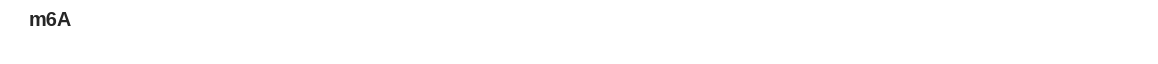

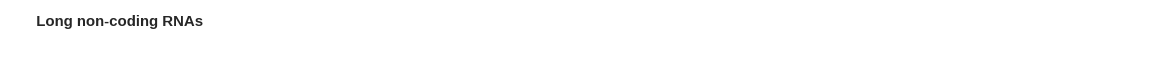

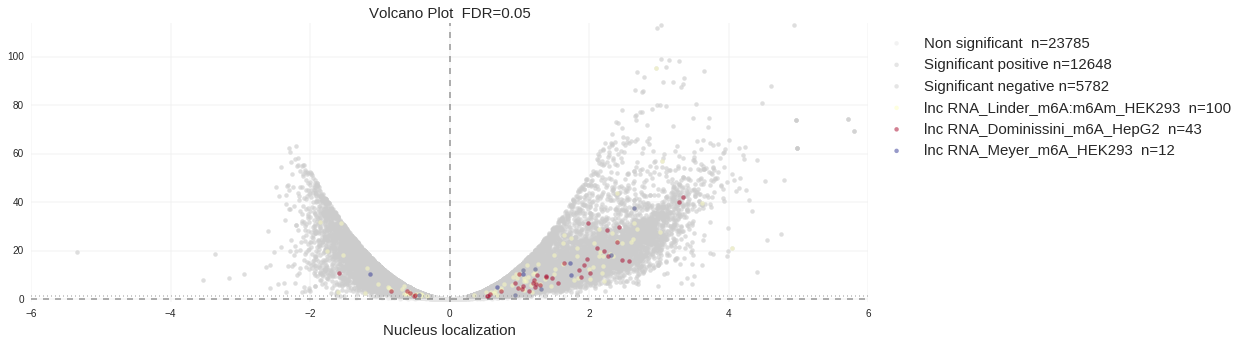

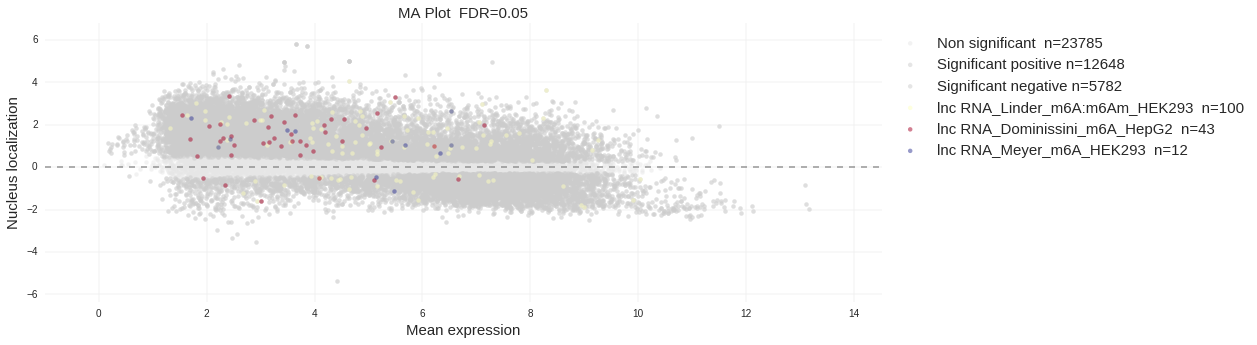

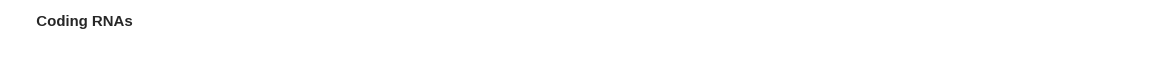

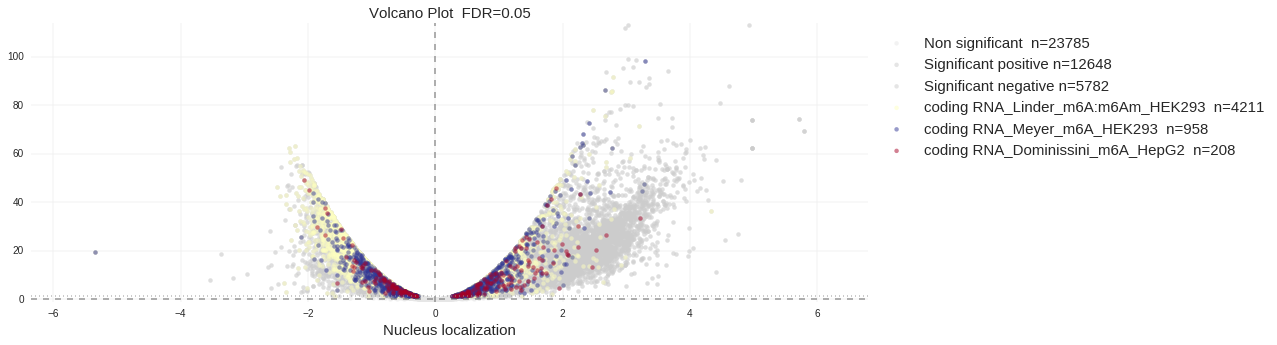

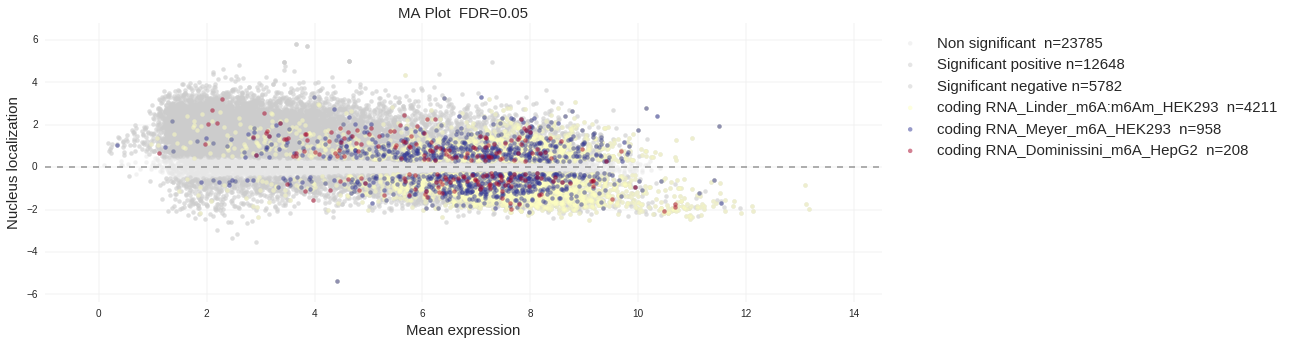

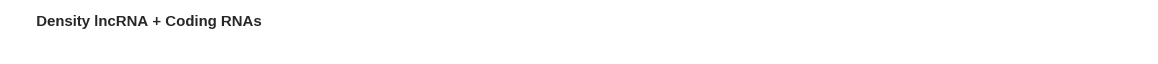

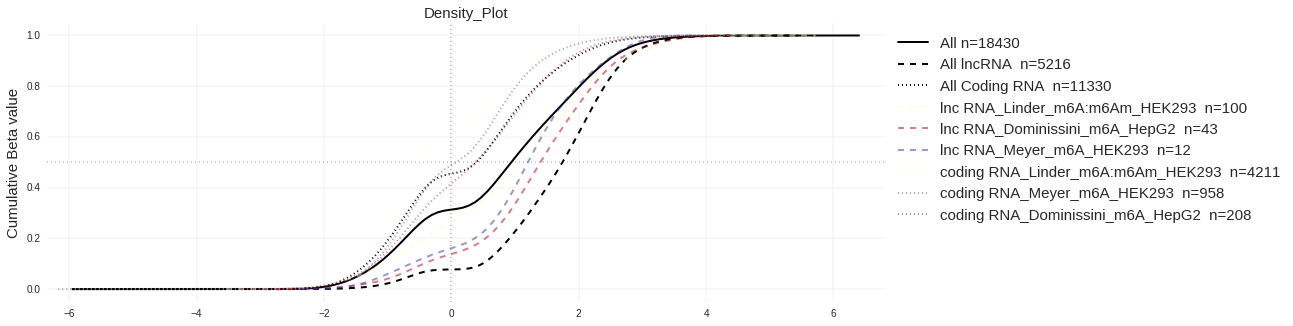

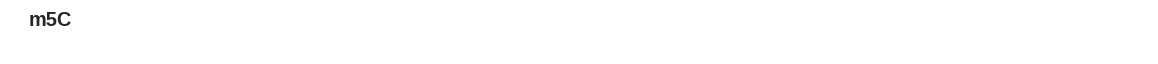

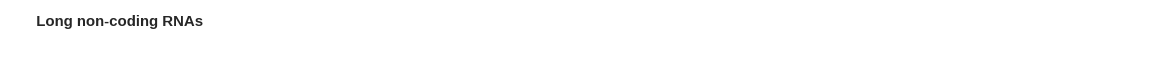

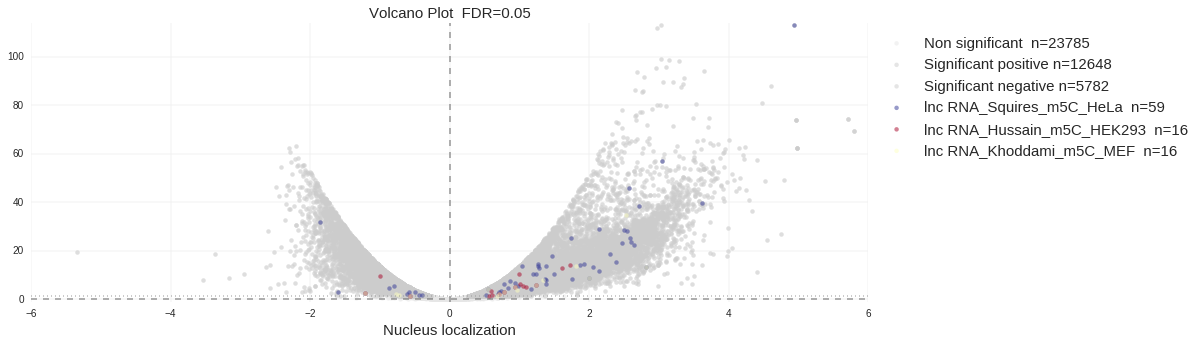

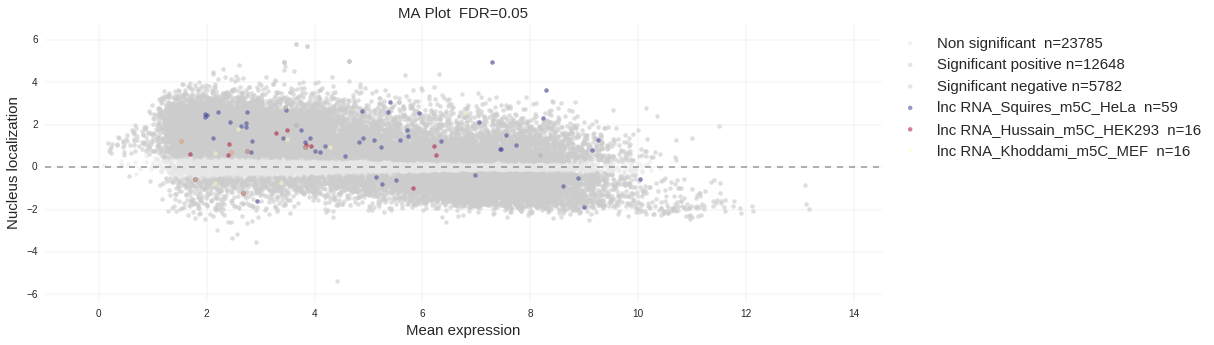

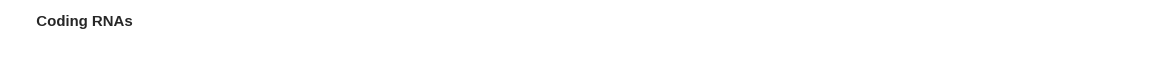

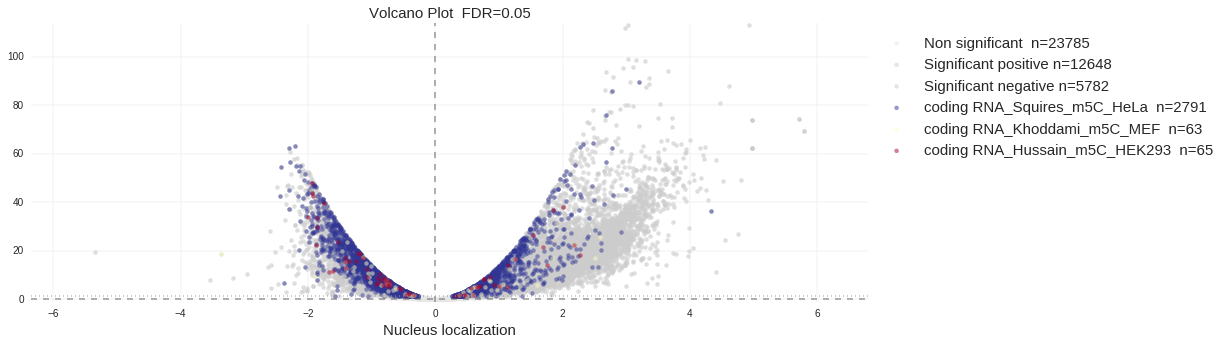

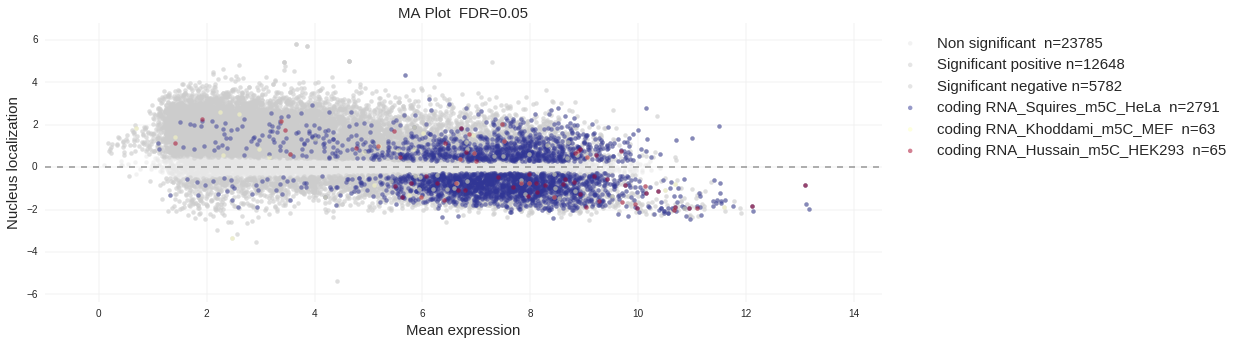

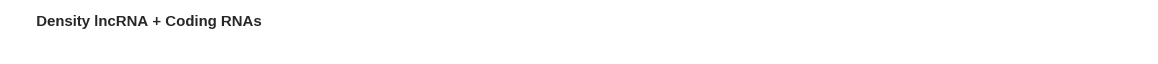

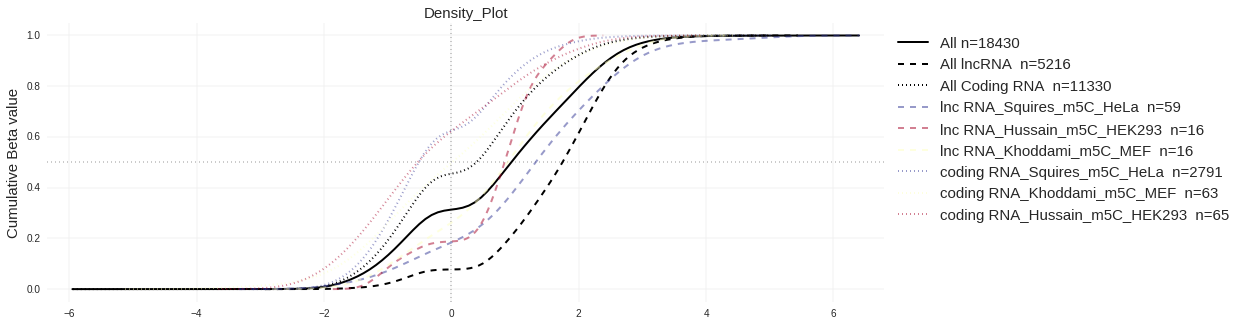

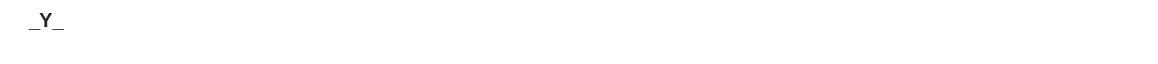

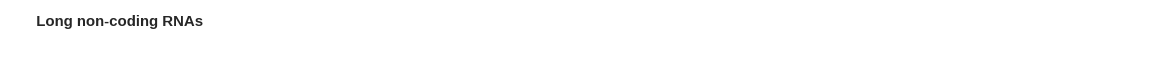

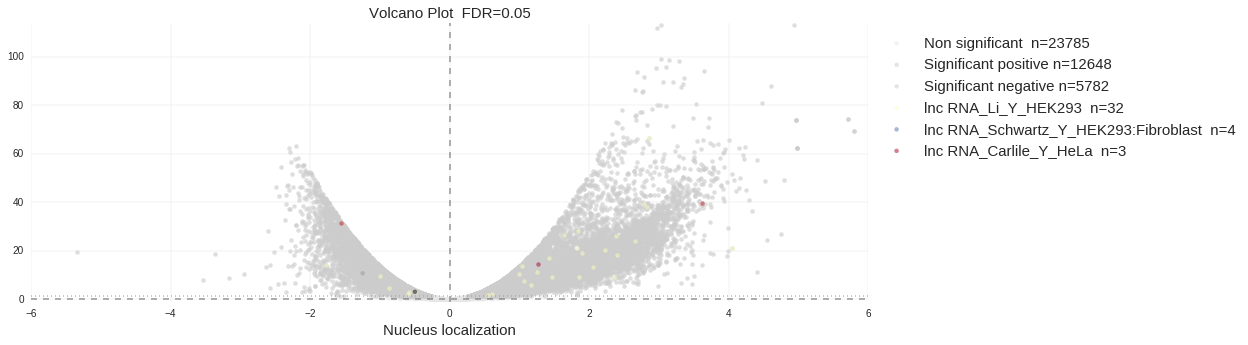

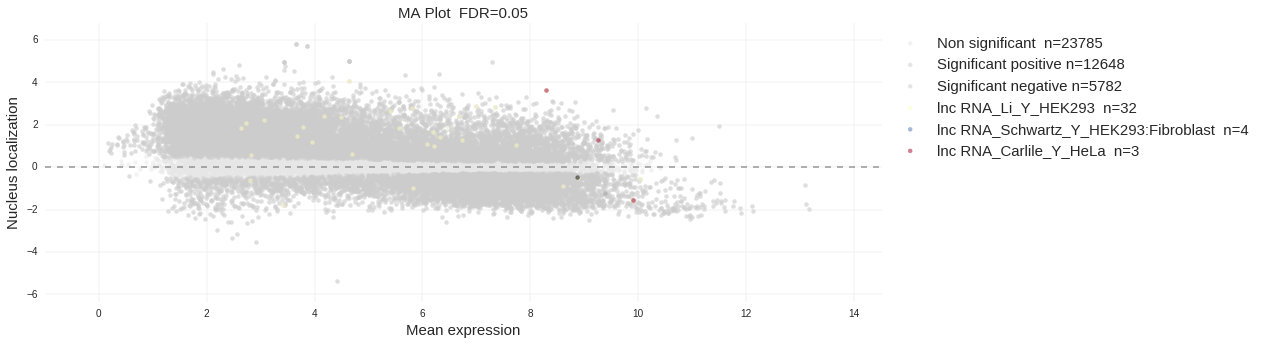

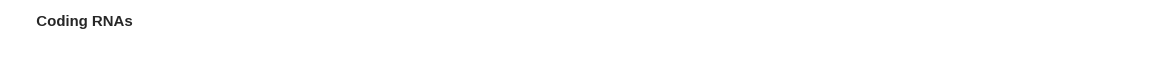

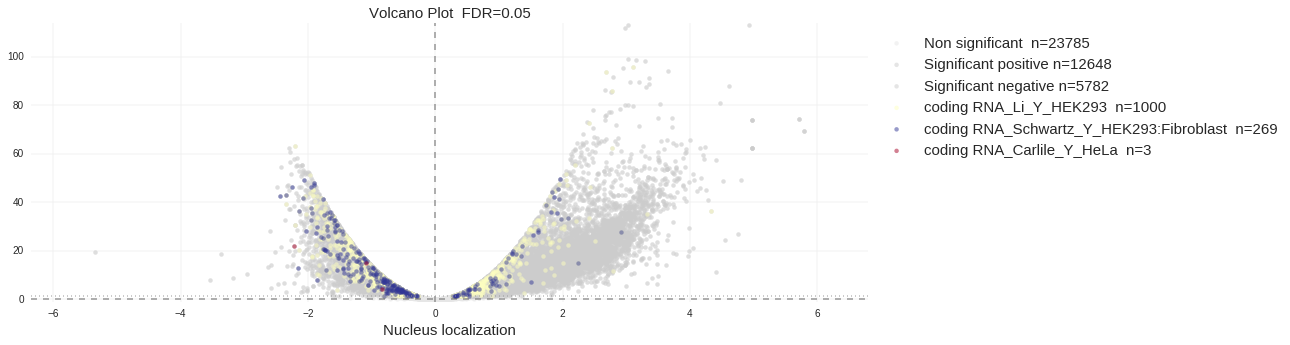

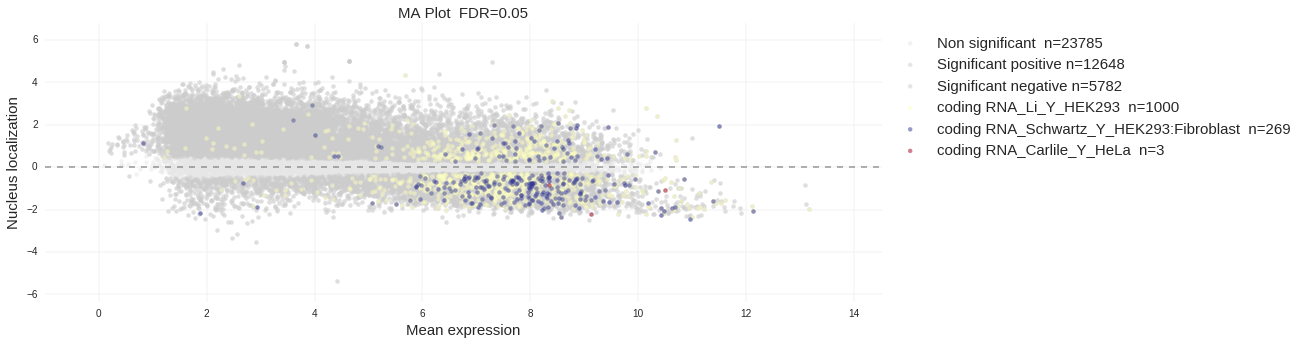

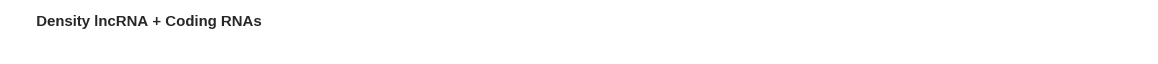

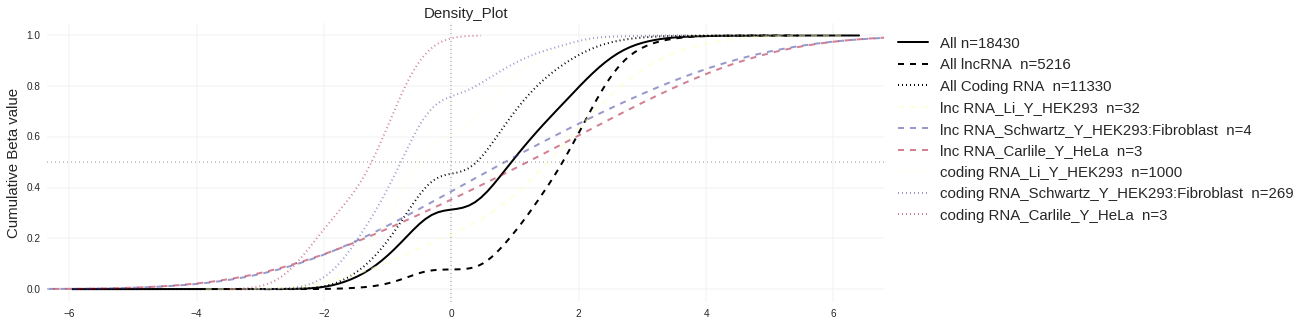

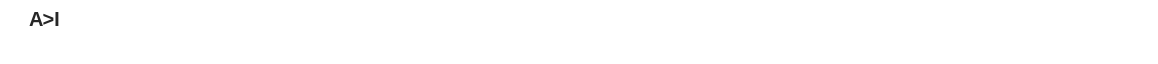

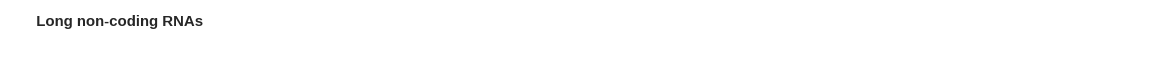

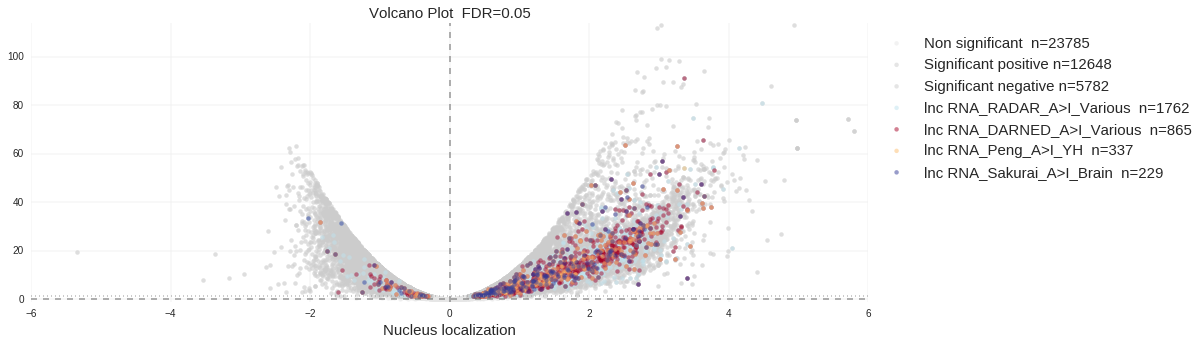

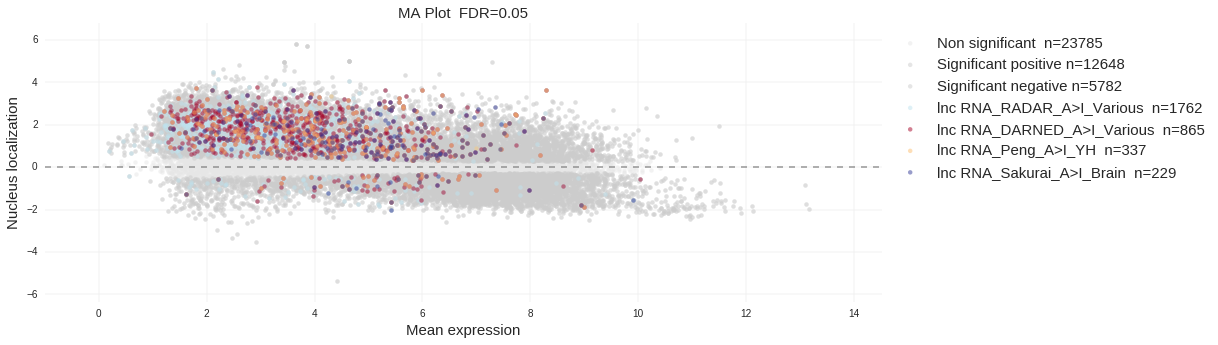

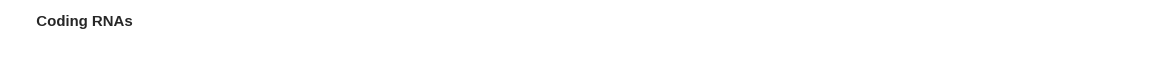

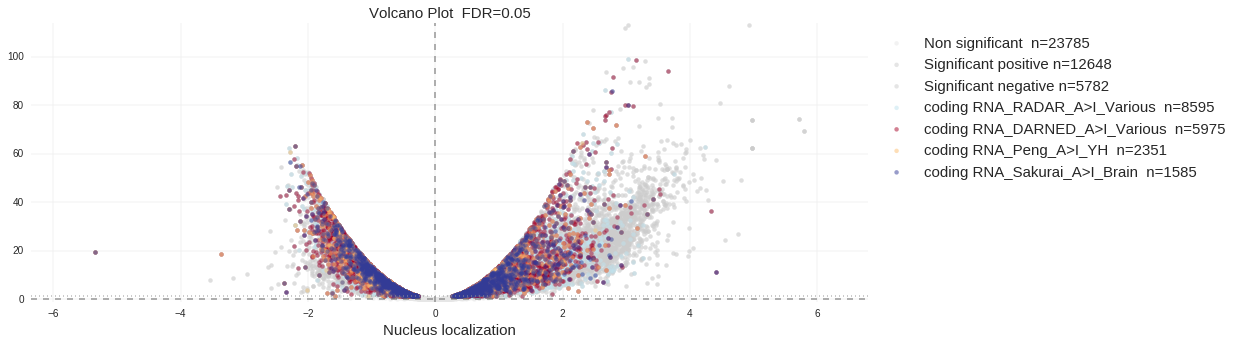

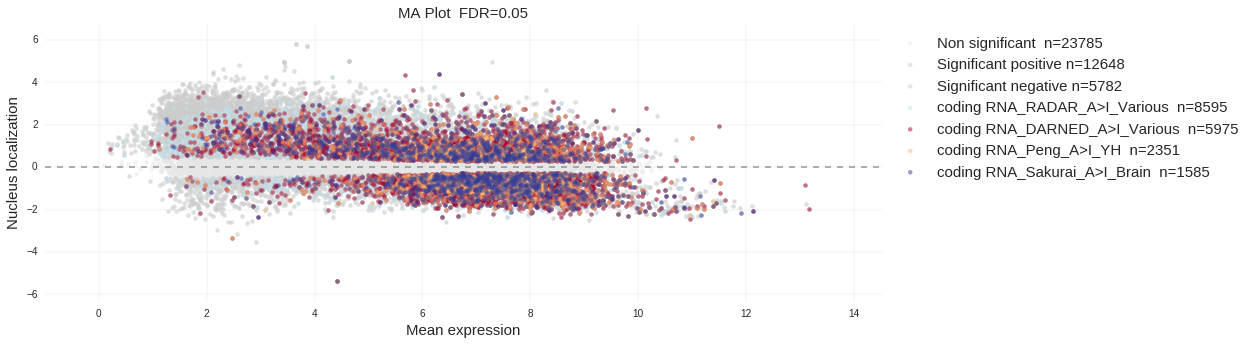

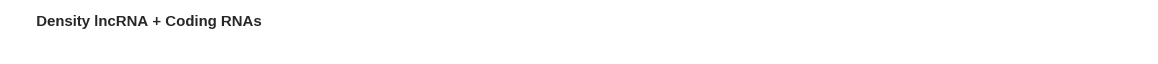

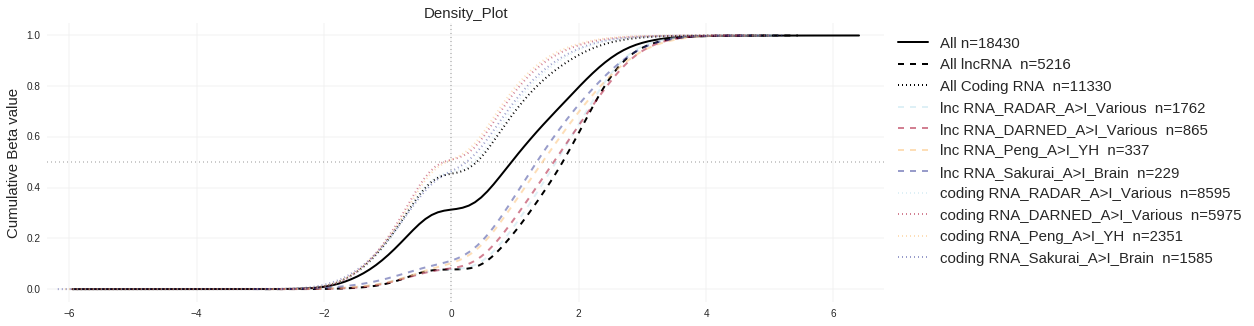

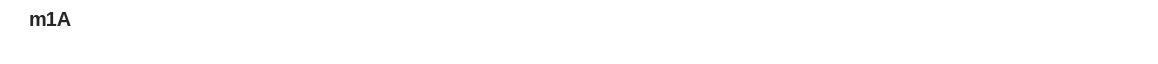

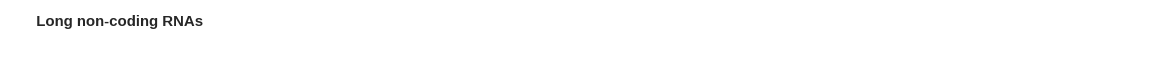

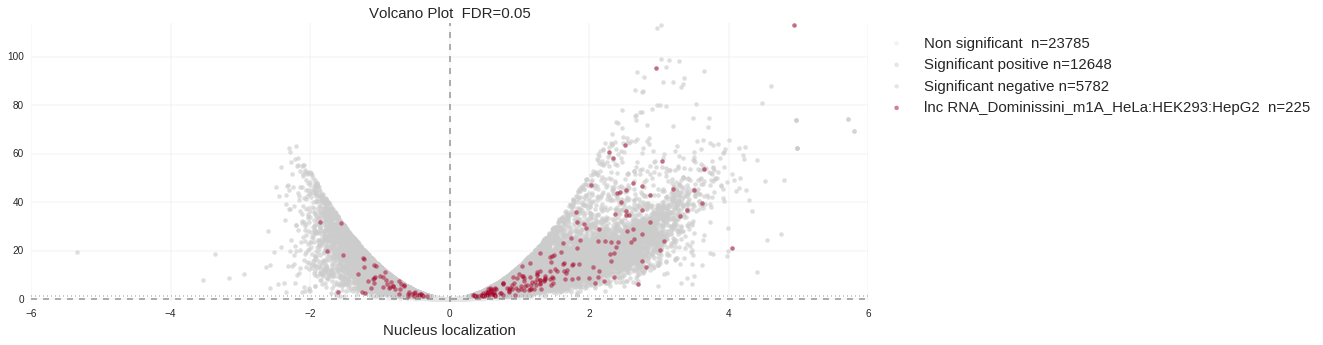

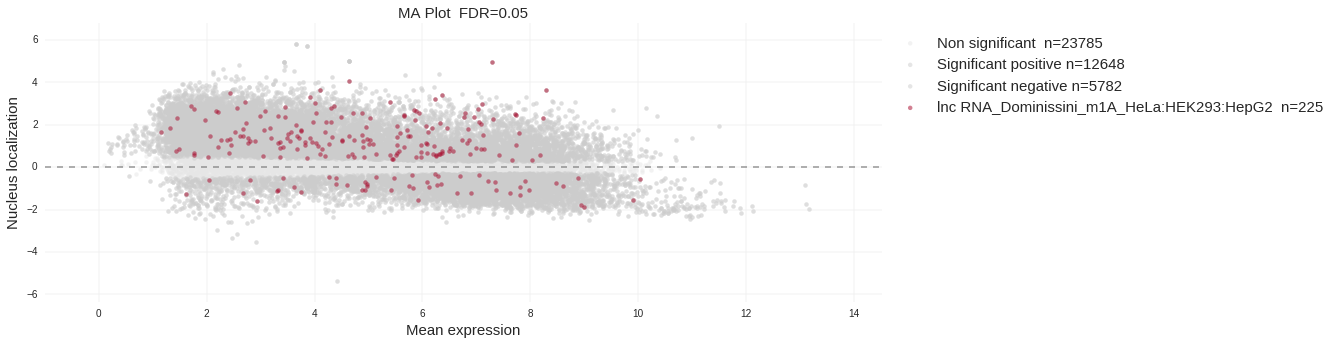

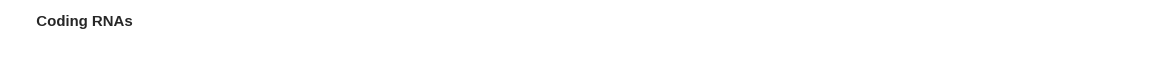

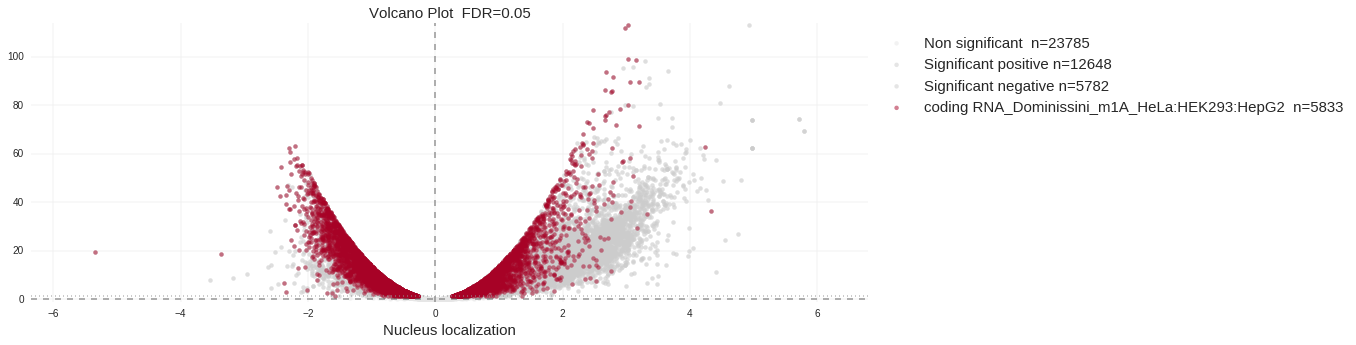

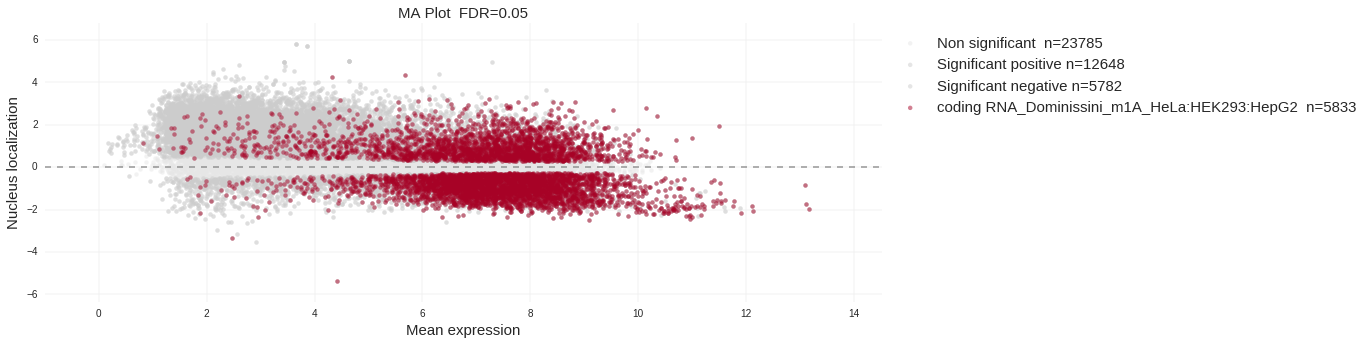

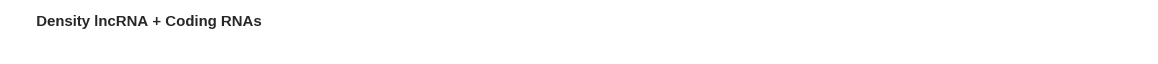

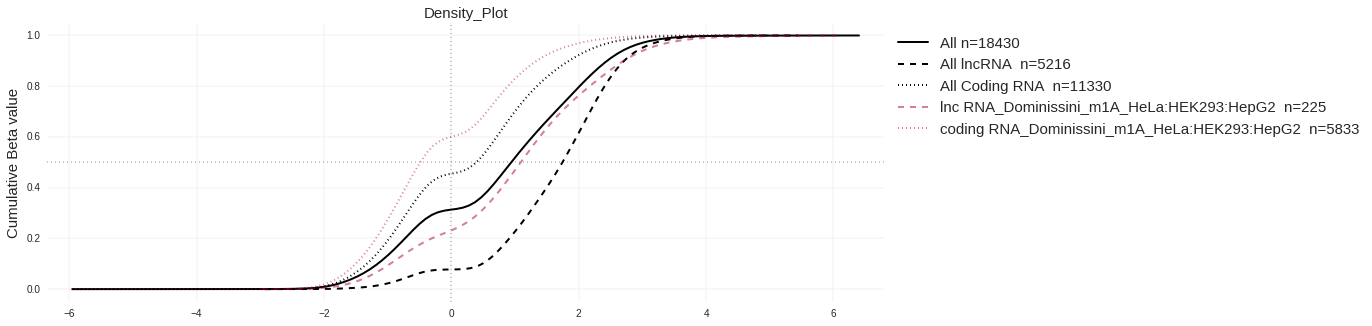

In [3]:
FDR = 0.05

# Define the categories of lnc and coding RNA
lncRNA_types = ["lincRNA", "antisense", "TEC", "sense_intronic", "processed_transcript", "sense_overlapping", "3prime_overlapping_ncrna", "non_coding", "bidirectional_promoter_lncrna", "macro_lncRNA"]
coding_RNA_types = ["protein_coding", "transcribed_processed_pseudogene", "transcribed_unitary_pseudogene", "translated_unprocessed_pseudogene"]

# Read the main data
df = pd.read_table("./Localisation/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")

# Deal with the 2 rnatypes
gene_df = pd.read_table( "../../Reference_Annotation/gencode_v24_gene.tsv")
# Subsetting coding genes
coding_RNA_types = ["protein_coding", "transcribed_processed_pseudogene", "transcribed_unitary_pseudogene", "translated_unprocessed_pseudogene"]
codingRNA_id = gene_df.ID[(gene_df.gene_type.isin(coding_RNA_types))]
# Subsetting lncRNA genes
lncRNA_types = ["lincRNA", "antisense", "TEC", "sense_intronic", "processed_transcript", "sense_overlapping", "3prime_overlapping_ncrna", "non_coding", "bidirectional_promoter_lncrna", "macro_lncRNA"]
lncRNA_id = gene_df.ID[(gene_df.gene_type.isin(lncRNA_types))]

hl_types = [
    {"target_id":lncRNA_id, "label":"All lncRNA", "linestyle":'--', "color":"black"},
    {"target_id":codingRNA_id, "label":"All Coding RNA", "linestyle":':', "color":"black"},]

for modif in ["m6A", "m5C", "_Y_", "A>I", "m1A"]:  
    PTM_dataset_list = sorted(glob("./PTM/PTM_Annotated_Datasets/*{}*_hg38_cleaned_gencode_v24_uniq-gene.csv".format(modif)))
    hl_lncRNA = []
    hl_codingRNA = []
    color = get_color_list(n=len(PTM_dataset_list), colormap="RdYlBu")
    
    for fp in PTM_dataset_list:
        PTM_df = pd.read_table(fp, names=["target_id", "gene_name", "gene_type", "count"])
        c = next(color)
        
        # lncRNA
        hl_lncRNA.append({
                "target_id": PTM_df.target_id[(PTM_df.target_id.isin(lncRNA_id))],
                "label":"lnc RNA_{}".format(file_name(fp).split("_hg38_")[0]),
                "alpha":0.5, "linestyle":'--', "color":c})
        
        # codingRNA
        hl_codingRNA.append({
                "target_id": PTM_df.target_id[(PTM_df.target_id.isin(codingRNA_id))],
                "label":"coding RNA_{}".format(file_name(fp).split("_hg38_")[0]),
                "alpha":0.5, "linestyle":':', "color":c})
    
    plot_text(modif, align="left", fontsize=20, fontweight="bold")
    
    # lncRNA
    hl_lncRNA.sort(key=lambda x: len(x["target_id"]), reverse=True)
    plot_text("  Long non-coding RNAs", align="left", fontsize=15, fontweight="bold")
    volcano_plot (df=df, highlight_list=hl_lncRNA, X="b", Y="qval", FDR=FDR, X_cutoff=0, figsize=[15,5], 
                  xlabel = "Nucleus localization", xlim=[-6,6], alpha=0.5, sig_neg_color="0.8", sig_pos_color="0.8", non_sig_color="0.9", highlight_FDR=FDR)
    MA_plot (df=df, highlight_list=hl_lncRNA, X="mean_obs", Y="b", FDR=FDR, FDR_col="qval", figsize=[15,5],
             xlabel="Mean expression", ylabel="Nucleus localization", alpha=0.5, sig_neg_color="0.8", sig_pos_color="0.8", non_sig_color="0.9", highlight_FDR=FDR)
    
    # codingRNA
    hl_codingRNA.sort(key=lambda x: len(x["target_id"]), reverse=True)
    plot_text("  Coding RNAs", align="left", fontsize=15, fontweight="bold")
    volcano_plot (df=df, highlight_list=hl_codingRNA, X="b", Y="qval", FDR=FDR, X_cutoff=0, figsize=[15,5],
                  xlabel = "Nucleus localization", alpha=0.5, sig_neg_color="0.8", sig_pos_color="0.8", non_sig_color="0.9", highlight_FDR=FDR)
    MA_plot (df=df, highlight_list=hl_codingRNA, X="mean_obs", Y="b", FDR=FDR, FDR_col="qval", figsize=[15,5],
             xlabel="Mean expression", ylabel="Nucleus localization", alpha=0.5, sig_neg_color="0.8", sig_pos_color="0.8", non_sig_color="0.9", highlight_FDR=FDR)
    
    # Density plot with both RNA types
    HL = hl_types + hl_lncRNA + hl_codingRNA
    plot_text("  Density lncRNA + Coding RNAs", align="left", fontsize=15, fontweight="bold")
    density_plot(df[(df.qval <= FDR)], "b", figsize=[15,5], ylabel="Cumulative Beta value", highlight_list= HL, cumulative = True)

### Same analysis but centered on RNA types instead of PTM type

In [5]:
# Read the main data
df = pd.read_table("./Localisation/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")
# Read the tables containing all gencode genes information 
gene_df = pd.read_table( "../../Reference_Annotation/gencode_v24_gene.tsv")
# Define the types of RNA
RNA_type_list= OrderedDict()
RNA_type_list["protein_coding"] = gene_df.ID[(gene_df.gene_type == "protein_coding")]
RNA_type_list["lincRNA"] = gene_df.ID[(gene_df.gene_type == "lincRNA")]
RNA_type_list["antisense"] = gene_df.ID[(gene_df.gene_type == "antisense")]
RNA_type_list["TEC"] = gene_df.ID[(gene_df.gene_type == "TEC")]
RNA_type_list["sense_intronic"] = gene_df.ID[(gene_df.gene_type == "sense_intronic")]
RNA_type_list["misc_RNA"] = gene_df.ID[(gene_df.gene_type == "misc_RNA")]
RNA_type_list["processed_transcript"] = gene_df.ID[(gene_df.gene_type == "processed_transcript")]
RNA_type_list["sense_overlapping"] = gene_df.ID[(gene_df.gene_type == "sense_overlapping")]
RNA_type_list["pseudogenes"] = gene_df.ID[(gene_df.gene_type.isin(["processed_pseudogene","transcribed_unprocessed_pseudogene", "unprocessed_pseudogene", "transcribed_processed_pseudogene"]))]
RNA_type_list["short_RNA"] = gene_df.ID[(gene_df.gene_type.isin(["miRNA","snoRNA","snRNA"]))]

for RNA_type, gene_id_list in RNA_type_list.items():
    print("{:20}\tcount: {}".format(RNA_type, len(gene_id_list)))


protein_coding      	count: 19815
lincRNA             	count: 7674
antisense           	count: 5564
TEC                 	count: 1053
sense_intronic      	count: 919
misc_RNA            	count: 2298
processed_transcript	count: 502
sense_overlapping   	count: 193
pseudogenes         	count: 14022
short_RNA           	count: 6938


using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


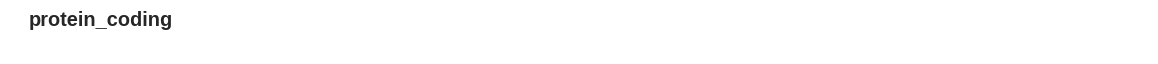

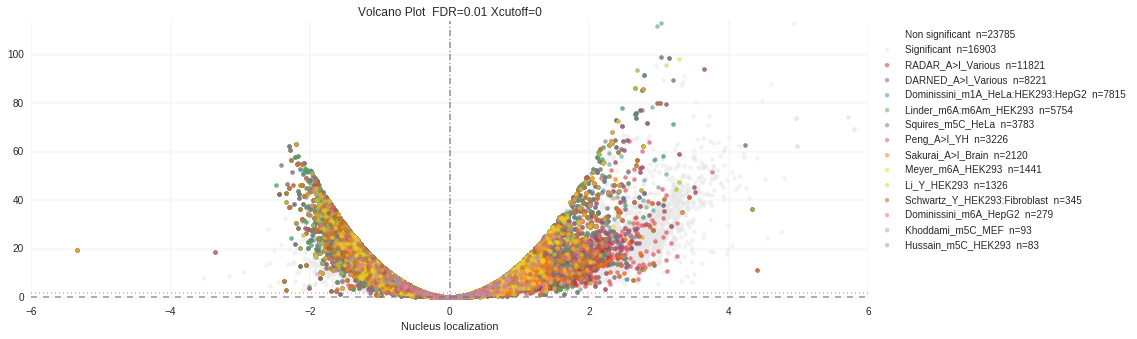

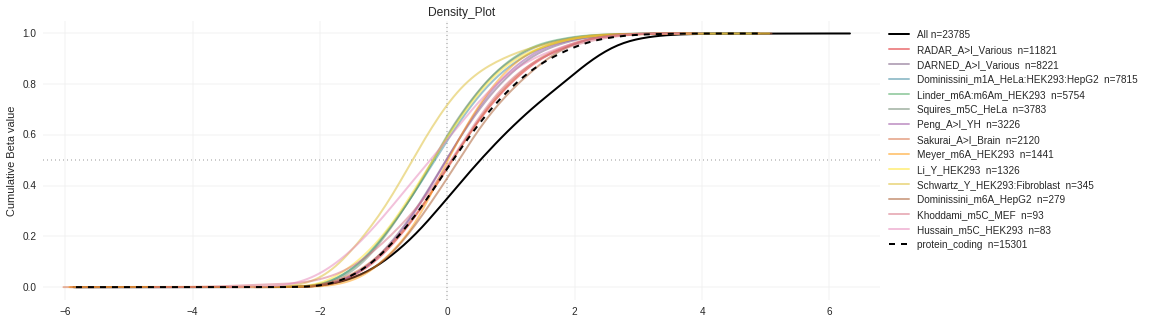

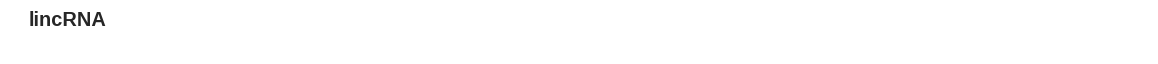

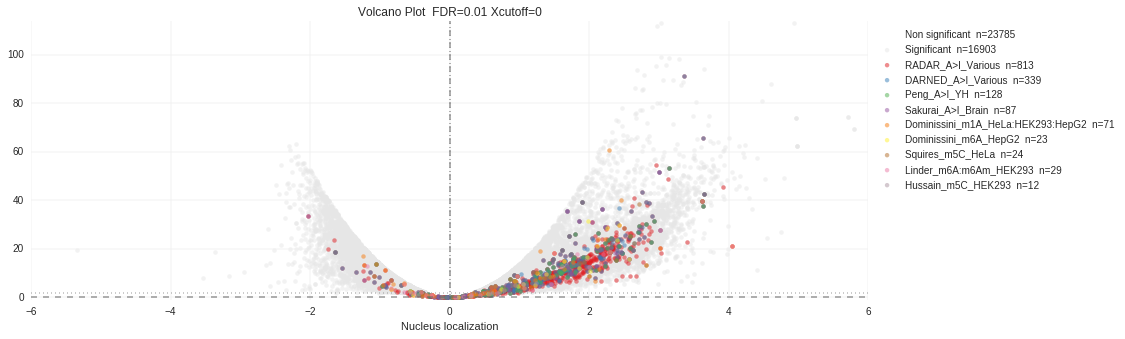

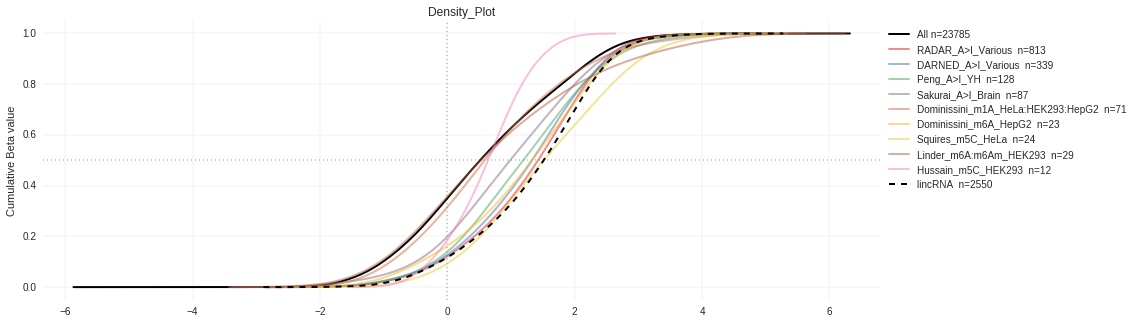

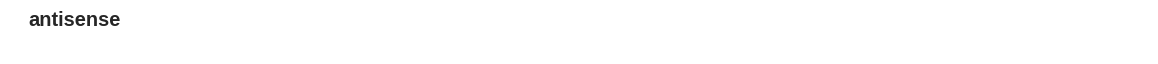

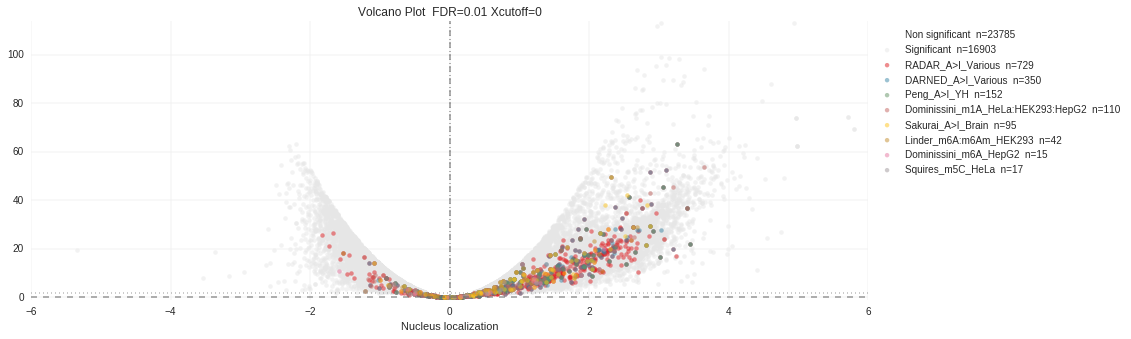

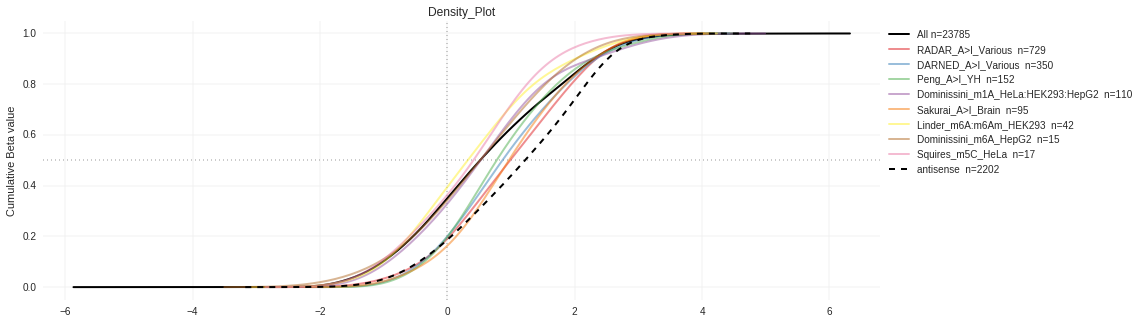

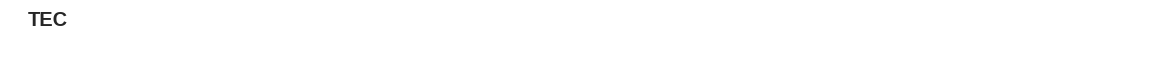

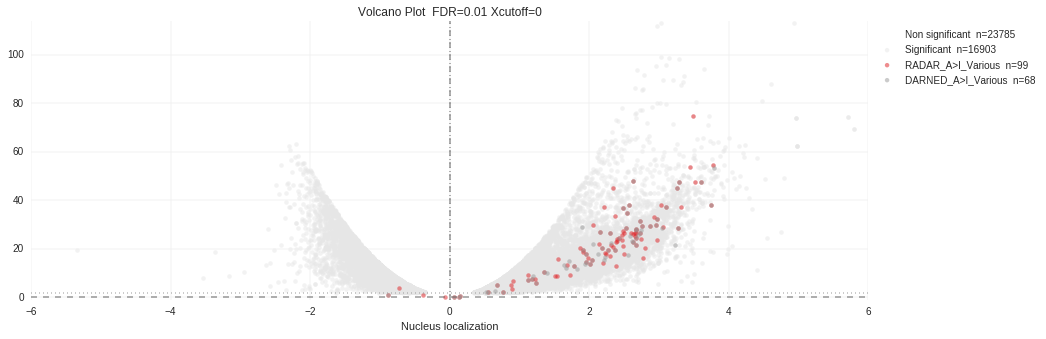

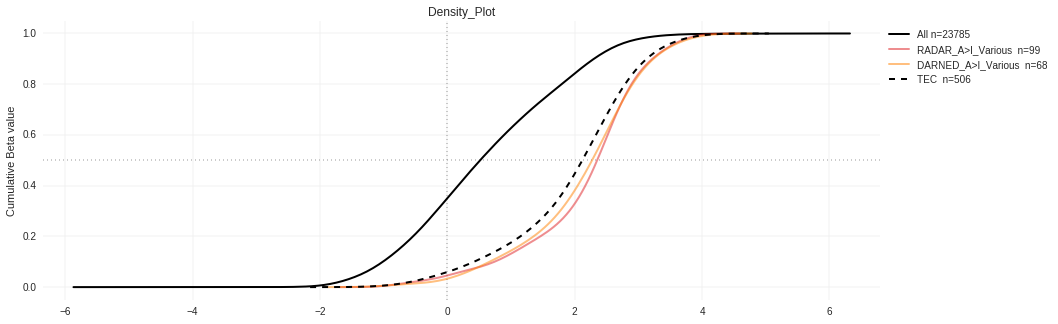

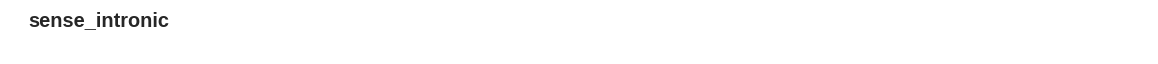

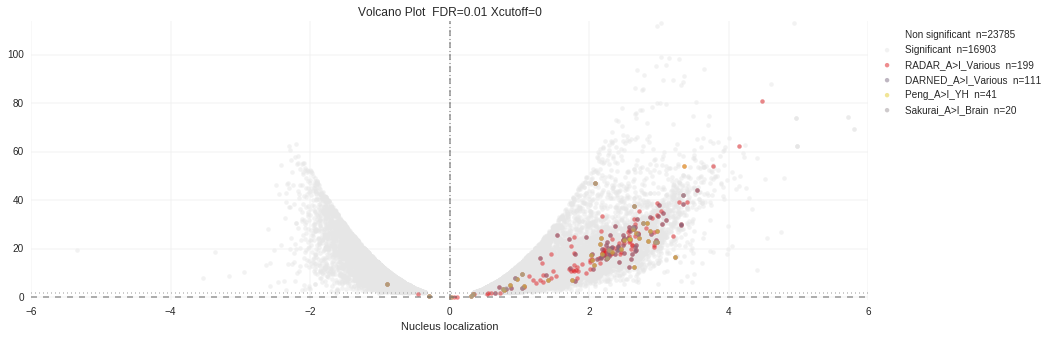

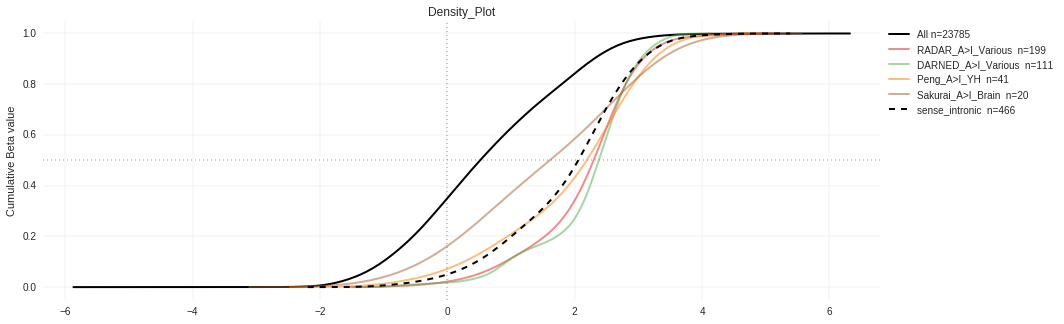

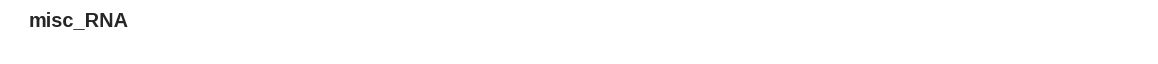

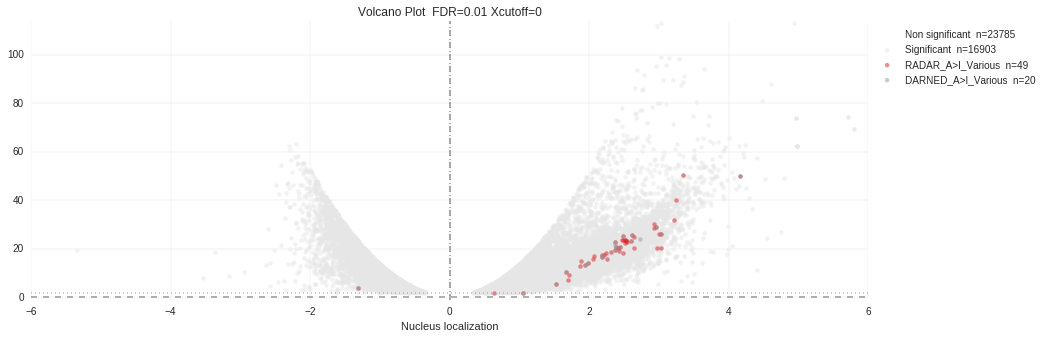

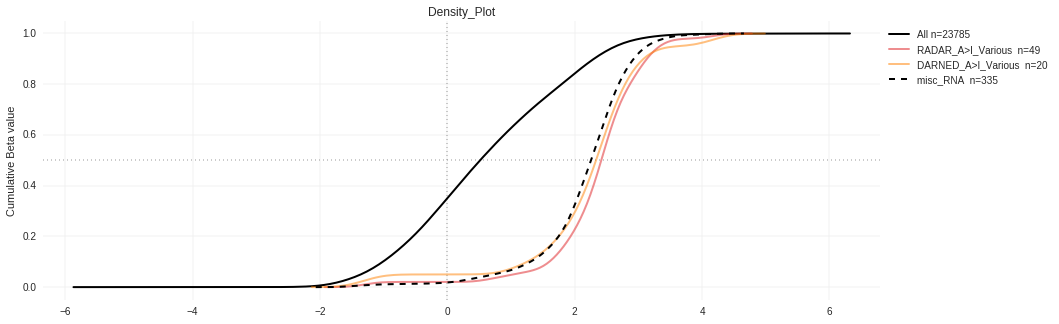

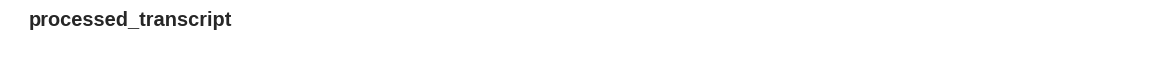

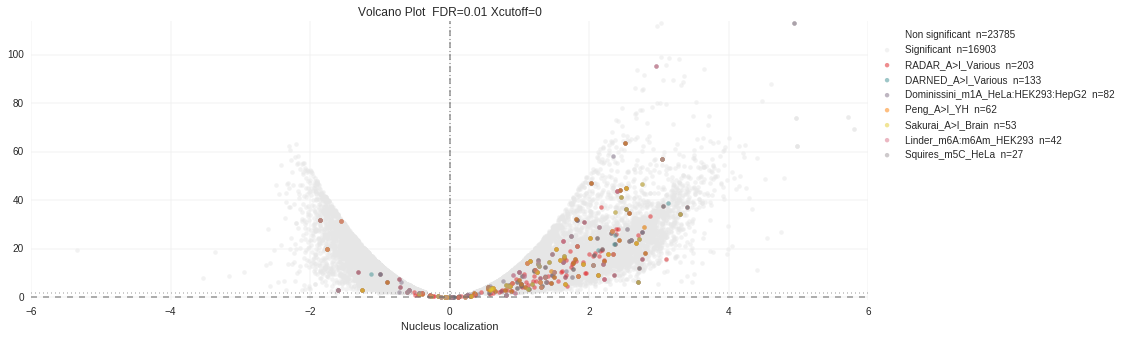

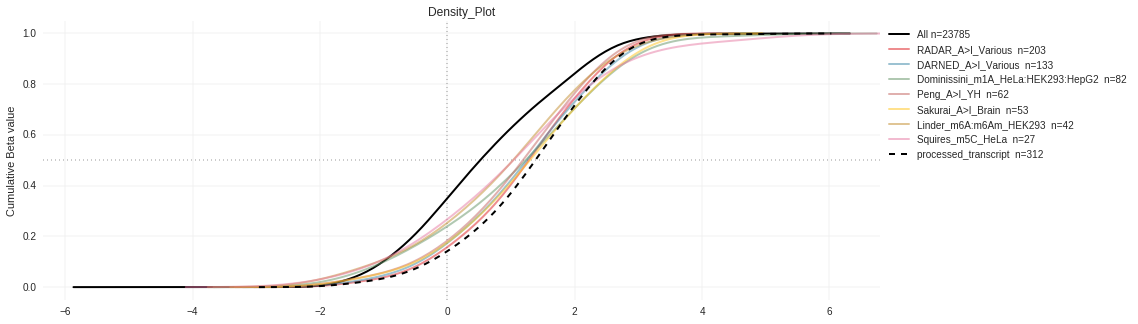

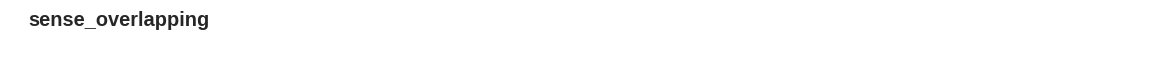

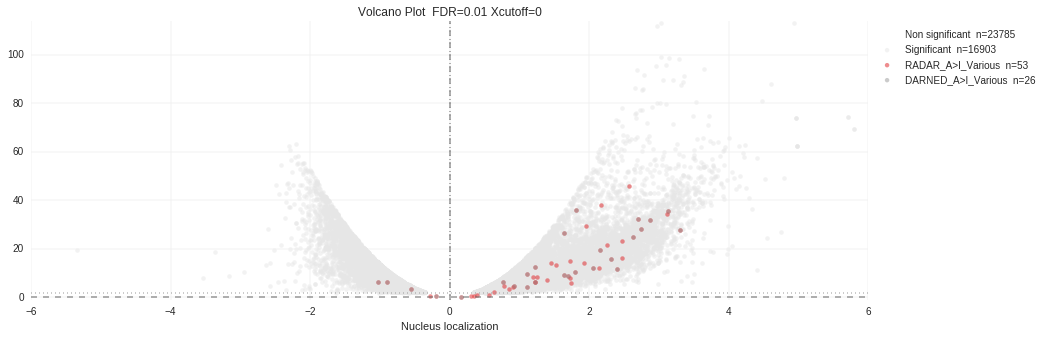

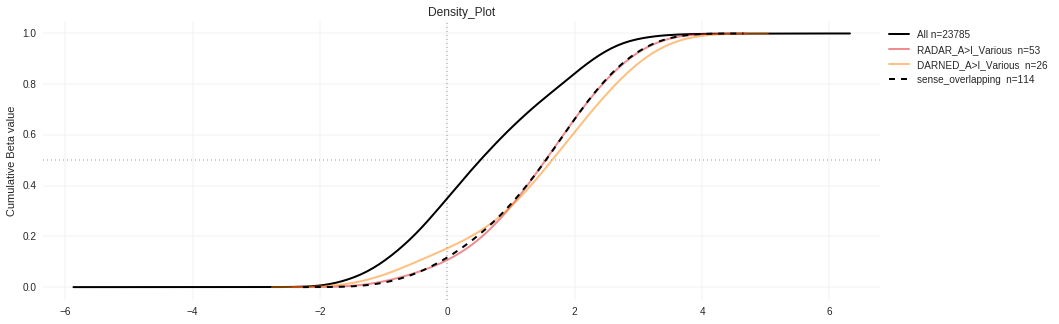

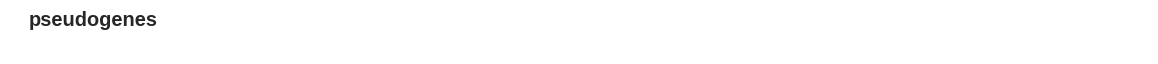

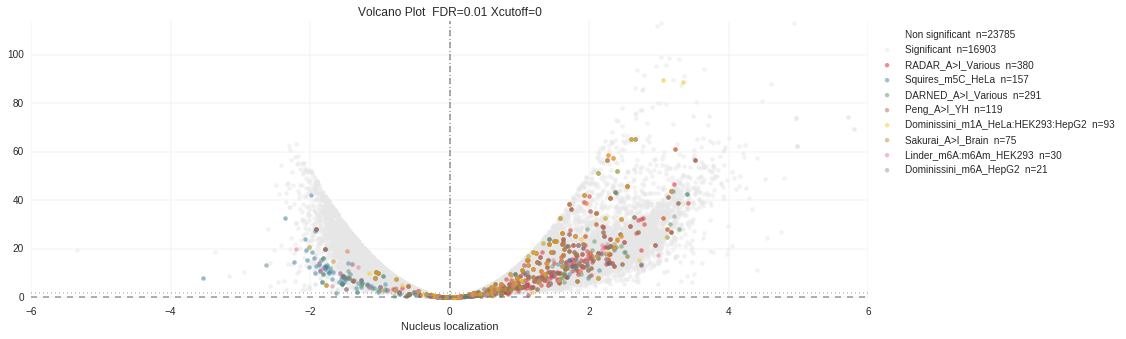

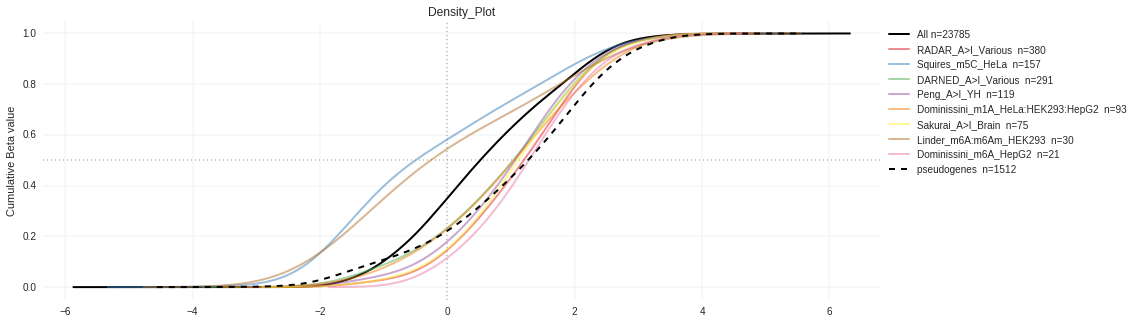

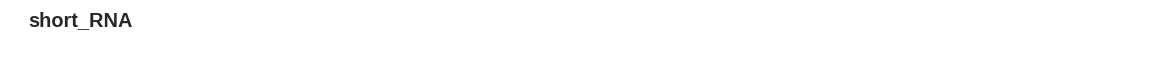

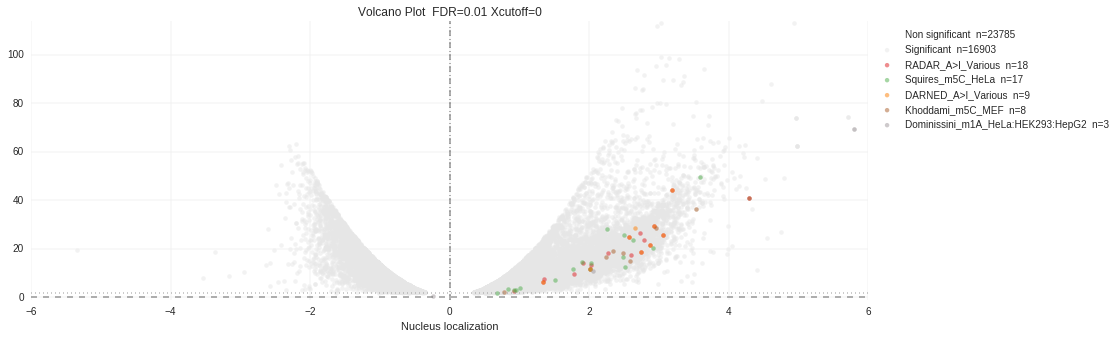

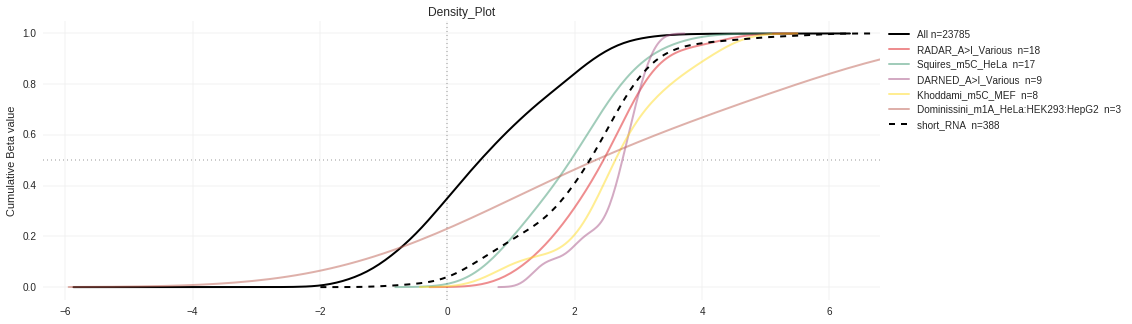

In [6]:
for RNA_type, gene_id_list in RNA_type_list.items():
    hl=[]
    for fp in sorted(glob("./PTM/PTM_Annotated_Datasets/*_hg38_cleaned_gencode_v24_uniq-gene.csv".format(modif))):
        PTM_df = pd.read_table(fp, names=["target_id", "gene_name", "gene_type", "count"])
        PTM_hl_list = PTM_df.target_id[(PTM_df.target_id.isin(gene_id_list))]
        
        if len(PTM_hl_list)>=20:
            hl.append({
                "target_id": PTM_hl_list,
                "label":file_name(fp).split("_hg38_")[0],
                "alpha":0.5})
        else:
            pass
        
    plot_text(RNA_type, align="left", fontsize=20, fontweight="bold")
    hl.sort(key=lambda x: len(x["target_id"]), reverse=True)
    volcano_plot (df=df, highlight_list=hl, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[15,5], xlabel = "Nucleus localization", sig_color="0.9", non_sig_color="1", xlim=[-6,6], alpha=0.5)
    HL = hl+[{"target_id":gene_id_list, "label":RNA_type, "linestyle":'--', "color":"black"}]
    density_plot(df, "b", figsize=[15,5], ylabel="Cumulative Beta value", highlight_list= HL, cumulative = True)

---
## Comparison lncRNA PTM datasets / lncRNA Localization at transcript level


**Considering the methods used by most of the genome wide PTM investigation I don't know if it is possible to determine the transcript of origin of the modified RNA ?? Possibility to use Kallisto or other methods eventually perform a transcript level analysis.**
*
*
*
*

---
## Comparison Localization datasets / RNA protein interaction

### Summary of the datasets

In [7]:
df = pd.read_csv("./Protein_interaction/Li_ClipSeq/Protocol_info/Selected_datasets.csv", sep="\t", index_col=0)
df

protein experiment cell_line  replicate  \
Dataset name                                           
HPAR1           FXR1   PAR-CLIP    HEK293          1   
HPTA1           AGO1   PAR-CLIP    HEK293          1   
HPTA3           AGO3   PAR-CLIP    HEK293          1   
HPTA4           AGO4   PAR-CLIP    HEK293          1   
HPTPU           PUM2   PAR-CLIP    HEK293          1   
HPTLB         LIN28B   PAR-CLIP    HEK293          1   
HPRO6           AGO1   PAR-CLIP    HEK293          1   
HPRO7           AGO1   PAR-CLIP    HEK293          2   
HPRO8           AGO1   PAR-CLIP    HEK293          3   
HPLAL         ALKBH5   PAR-CLIP    HEK293          1   
HPLZC         ZC3H7B   PAR-CLIP    HEK293          1   
HPHFW            FUS   PAR-CLIP    HEK293          1   
HPHTA          TAF15   PAR-CLIP    HEK293          1   
HIUHN         hnRNPC      iCLIP      HeLa          1   
HHCD1          DGCR8  HITS-CLIP    HEK293          1   
HHCD2          DGCR8  HITS-CLIP    HEK293          2   
HHMF1            FUS  HITS-CLIP     Brain          1   
HHMF2            FUS  HITS-CLIP     Brain          2   
HHMF3            FUS  HITS-CLIP     Brain          3   
HIUHC         hnRNPC      iCLIP      HeLa          1   

                                           treatment localization   author  \
Dataset name                                                                 
HPAR1         wildtype FXR1, 4-thiouridine, RNase T1      cytosol   ascano   
HPTA1                        4-thiouridine, RNase T1      cytosol   hafner   
HPTA3                        4-thiouridine, RNase T1      cytosol   hafner   
HPTA4                        4-thiouridine, RNase T1      cytosol   hafner   
HPTPU                        4-thiouridine, RNase T1      cytosol   hafner   
HPTLB                        4-thiouridine, RNase T1      cytosol   hafner   
HPRO6                         4-thiouridine, ML_MM_6      cytosol  memczak   
HPRO7                         4-thiouridine, ML_MM_7      cytosol  memczak   
HPRO8                         4-thiouridine, ML_MM_8      cytosol  memczak   
HPLAL                                  4-thiouridine      nucleus    baltz   
HPLZC                                  4-thiouridine      nucleus    baltz   
HPHFW                                  4-thiouridine      nucleus    hoell   
HPHTA                                  4-thiouridine      nucleus    hoell   
HIUHN                                              -      nucleus    konig   
HHCD1             D8 (endogenous DGCR8), replicate 1      nucleus   macias   
HHCD2             D8 (endogenous DGCR8), replicate 2      nucleus   macias   
HHMF1                           replicate1, RNase T1      nucleus   nakaya   
HHMF2                           replicate2, RNase T1      nucleus   nakaya   
HHMF3                           replicate3, RNase T1      nucleus   nakaya   
HIUHC                                      untreated      nucleus  zarnack   

                      accession  \
Dataset name                      
HPAR1                  GSE39682   
HPTA1                  GSE21918   
HPTA3                  GSE21918   
HPTA4                  GSE21918   
HPTPU                  GSE21918   
HPTLB                  GSE44615   
HPRO6                  GSE43573   
HPRO7                  GSE43573   
HPRO8                  GSE43573   
HPLAL                  GSE38201   
HPLZC                  GSE38201   
HPHFW                 SRA025082   
HPHTA                 SRA025082   
HIUHN         SupplementaryData   
HHCD1                  GSE39086   
HHCD2                  GSE39086   
HHMF1                  GSE43308   
HHMF2                  GSE43308   
HHMF3                  GSE43308   
HIUHC               E-MTAB-1371   

                                                       filepath  
Dataset name                                                     
HPAR1         /home/aleg/Data/Datasets/Epi2_pilot/Protein_in...  
HPTA1         /home/aleg/Data/Datasets/Epi2_pilot/Protein_in...  
HPTA3         /home/aleg/Dat

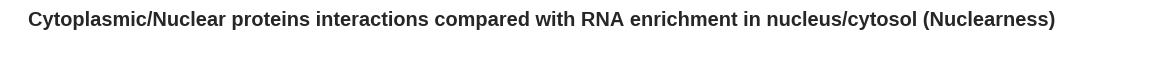

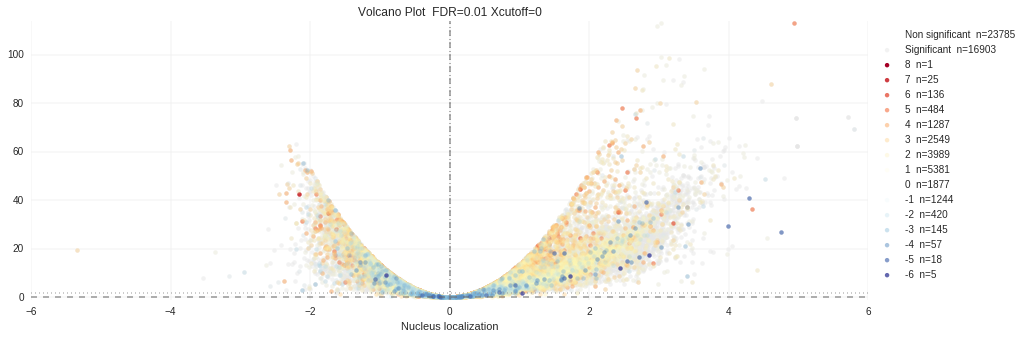

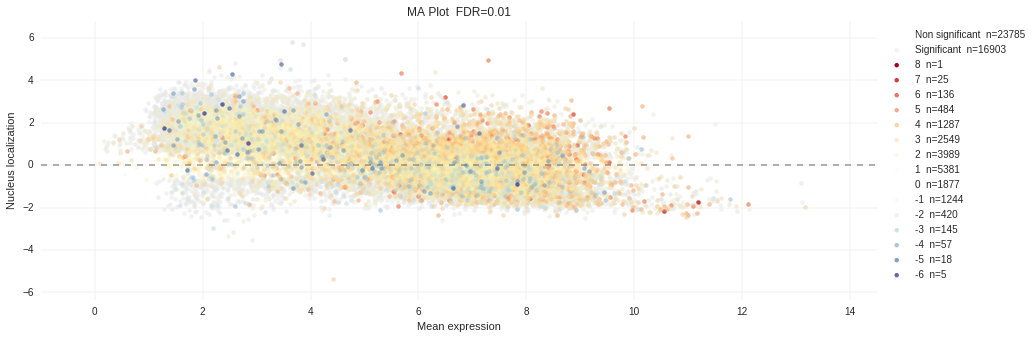

In [38]:
# Read the localization data
loc_df = pd.read_table("./Localisation/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")
# Read the interaction data
protein_df = pd.read_table("./Protein_interaction/Li_ClipSeq/final_datasets/ALL_dataset_uniq_genes.tsv")

nuclearness_list=[]
    
for i in range(protein_df["nuclearness"].unique().max(), protein_df["nuclearness"].unique().min()-1, -1):
    nuclearness_list.append({
        "target_id": protein_df.gene_id[protein_df.nuclearness==i],
        "label":str(i), "alpha":abs(i)/protein_df.nuclear_protein.max(), "linestyle":'--'})

plot_text("Cytoplasmic/Nuclear proteins interactions compared with RNA enrichment in nucleus/cytosol (Nuclearness)", align="left", fontsize=20, fontweight="bold")
volcano_plot (df=loc_df, highlight_list=nuclearness_list, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[15,5], 
              xlabel = "Nucleus localization", sig_color="0.9", non_sig_color="1", xlim=[-6,6], alpha=0.5, highlight_palette="RdYlBu")
MA_plot (df=loc_df, highlight_list=nuclearness_list, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[15,5], 
         xlabel="Mean expression", ylabel="Nucleus localization", sig_color="0.9", non_sig_color="1", alpha=0.5, highlight_palette="RdYlBu")


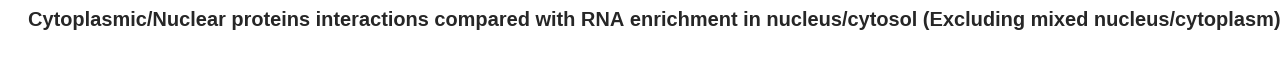

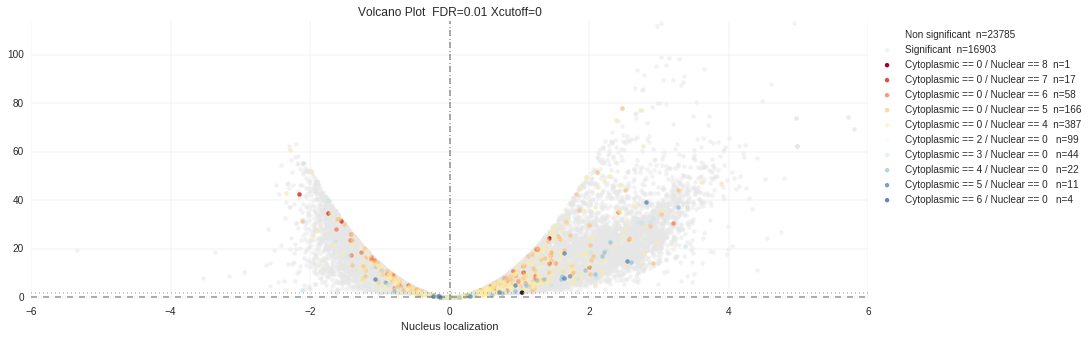

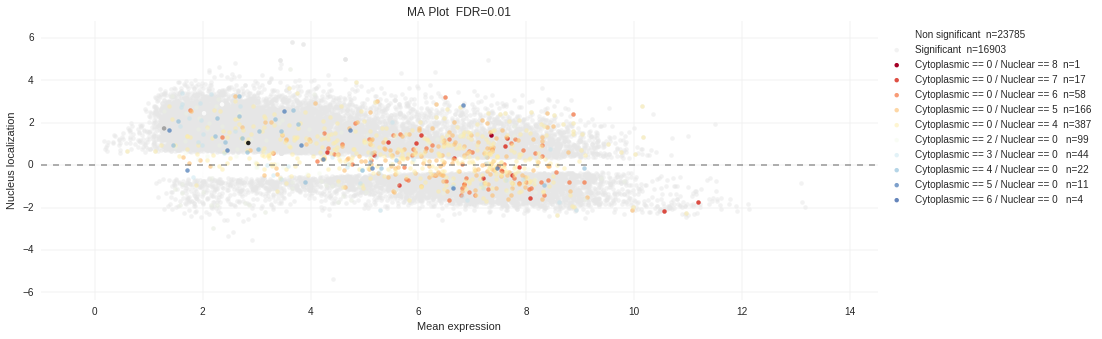

In [34]:
# Read the localization data
loc_df = pd.read_table("./Localisation/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")
# Read the interaction data
protein_df = pd.read_table("./Protein_interaction/Li_ClipSeq/final_datasets/ALL_dataset_uniq_genes.tsv")

loc_list=[]
for i in range(protein_df.nuclear_protein.max(),3, -1):
    loc_list.append({
            "target_id": protein_df.gene_id[(protein_df.cytosol_protein==0) & (protein_df.nuclear_protein==i)],
            "label":"Cytoplasmic == 0 / Nuclear == {}".format(i), "alpha":i/protein_df.nuclear_protein.max()})

range_cytosol = range(2, protein_df.cytosol_protein.max())
for i in range_cytosol:
    loc_list.append({
            "target_id": protein_df.gene_id[(protein_df.cytosol_protein==i) & (protein_df.nuclear_protein==0)],
            "label":"Cytoplasmic == {} / Nuclear == 0 ".format(i), "alpha":i/protein_df.cytosol_protein.max()})

plot_text("Cytoplasmic/Nuclear proteins interactions compared with RNA enrichment in nucleus/cytosol (Excluding mixed nucleus/cytoplasm)", align="left", fontsize=20, fontweight="bold")
volcano_plot (df=loc_df, highlight_list=loc_list, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[15,5], 
              xlabel = "Nucleus localization", sig_color="0.9", non_sig_color="1", xlim=[-6,6], alpha=0.5, highlight_palette="RdYlBu")
MA_plot (df=loc_df, highlight_list=loc_list, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[15,5], 
         xlabel="Mean expression", ylabel="Nucleus localization", sig_color="0.9", non_sig_color="1", alpha=0.5, highlight_palette="RdYlBu")

**Hard to interpret because the nuclear protein seems to associate mainly with low expression genes (lncRNA ?) while cytoplasmic protein are found enriched in high expression proteins... THe nature of the selected proteins makes it hard to draw any clear conclusion. I don't think it can be used further on..** 